# 0.方法

- Paper: https://link.springer.com/article/10.1007/s10618-016-0483-9
<!-- - GitHub: https://github.com/hfawaz/dl-4-tsc/ -->

# 1.Setup

In [1]:
import config
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
print(tf.__version__)

2.4.1


# 1.数据加载、数据探索、数据预处理

## 1.0 数据描述

- Data discription: http://www.j-wichard.de/publications/FordPaper.pdf
- Data: https://www.cs.ucr.edu/~eamonn/time_series_data_2018/

## 1.1 数据加载

In [2]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter = "\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)

In [3]:
x_train, y_train = readucr(config.train_data_dir)
x_test, y_test = readucr(config.test_data_dir)
classes = np.unique(np.concatenate((y_train, y_test), axis = 0))

In [4]:
print(f"x_train head 10={x_train[:10]}")
print(f"y_train head 10={y_train[:10]}")
print(f"x_train.shape={x_train.shape}")
print(f"y_train.shape={y_train.shape}")
print(f"x_test.shape={x_test.shape}")
print(f"y_test.shape={y_test.shape}")
print(f"classes={classes}")

x_train head 10=[[-0.79717168 -0.66439208 -0.37301463 ... -0.66439208 -1.0737958
  -1.5643427 ]
 [ 0.80485472  0.63462859  0.37347448 ... -0.71488505 -0.56044294
  -0.31908642]
 [ 0.7279851   0.11128392 -0.49912439 ...  0.39446303  0.33940042
   0.25539062]
 ...
 [ 1.0458903   0.61119521  0.15310839 ...  1.0131138   0.6744954
   0.33701418]
 [ 0.825565    0.38528249 -0.06241574 ...  1.268105    1.136557
   0.87434749]
 [-0.28418135 -0.1926089  -0.03229214 ...  0.39283548  0.46211729
   0.45075584]]
y_train head 10=[-1  1 -1 -1 -1  1  1  1  1  1]
x_train.shape=(3601, 500)
y_train.shape=(3601,)
x_test.shape=(1320, 500)
y_test.shape=(1320,)
classes=[-1  1]


## 1.2 数据探索

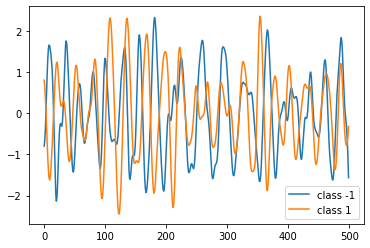

In [5]:
def data_visual(classes, x_train, y_train):
    plt.figure()
    for c in classes:
        c_x_train = x_train[y_train == c]
        plt.plot(c_x_train[0], label = "class " + str(c))
    plt.legend(loc = "best")
    plt.show()
    plt.close()

data_visual(classes, x_train, y_train)

## 1.3 数据预处理

In [6]:
# 重塑训练集、测试集
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
print(x_train.shape)
print(x_test.shape)

(3601, 500, 1)
(1320, 500, 1)


In [7]:
# 训练集类的数量
num_classes = len(np.unique(y_train))

In [8]:
# 训练接 shuffle
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train=  y_train[idx]

In [9]:
# 将标签标准化为正整数
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

# 2.模型构建

## 2.1 模型构建

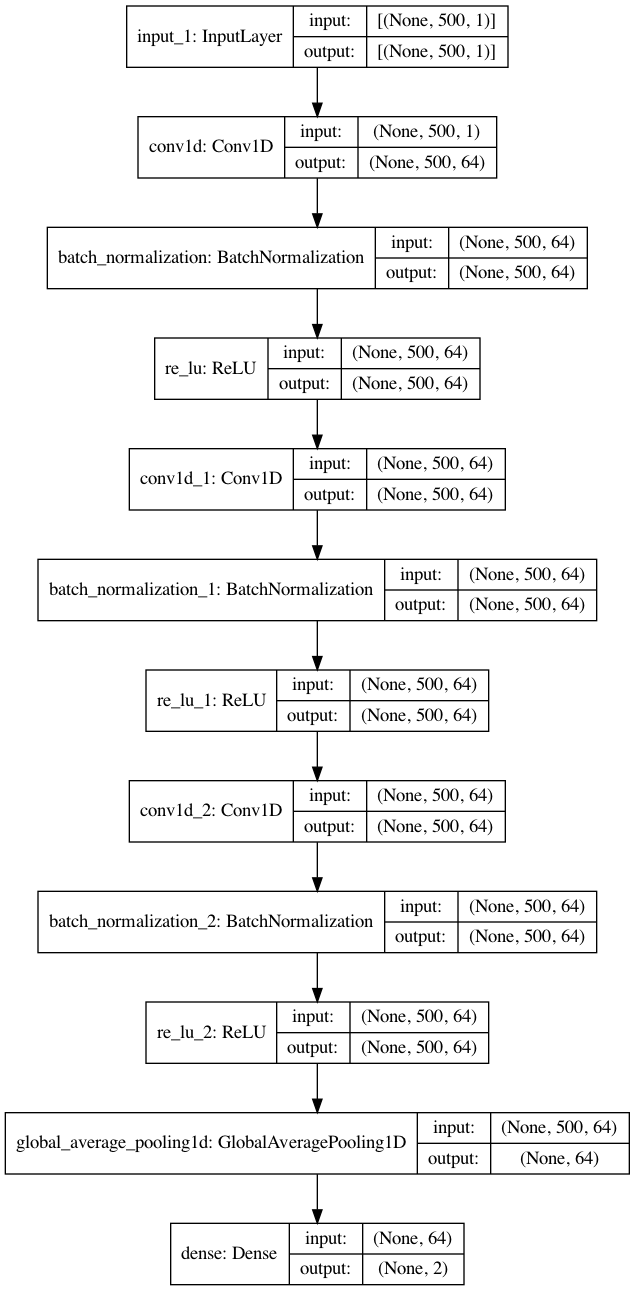

In [10]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)
    conv1 = keras.layers.Conv1D(filters = 64, kernel_size = 3, padding = "same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)
    
    conv2 = keras.layers.Conv1D(filters = 64, kernel_size = 3, padding = "same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)
    
    conv3 = keras.layers.Conv1D(filters = 64, kernel_size = 3, padding = "same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)
    
    gap = keras.layers.GlobalAveragePooling1D()(conv3)
    
    output_layer = keras.layers.Dense(num_classes, activation = "softmax")(gap)

    model = keras.models.Model(inputs = input_layer, outputs = output_layer)
    
    return model


model = make_model(input_shape = x_train.shape[1:])
keras.utils.plot_model(model, show_shapes = True)

## 2.2 模型编译、训练

In [13]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only = True, monitor = "val_loss"),
    keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 20, min_lr = 0.0001),
    keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 50, verbose = 1),
]
model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["sparse_categorical_accuracy"])
history = model.fit(
    x_train,
    y_train,
    batch_size = batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_split = 0.2,
    verbose = 1,
)

Epoch 1/500
90/90 [==============================] - 5s 47ms/step - loss: 0.0743 - sparse_categorical_accuracy: 0.9731 - val_loss: 3.9027 - val_sparse_categorical_accuracy: 0.5451
Epoch 2/500
90/90 [==============================] - 5s 57ms/step - loss: 0.0869 - sparse_categorical_accuracy: 0.9678 - val_loss: 0.1204 - val_sparse_categorical_accuracy: 0.9653
Epoch 3/500
90/90 [==============================] - 6s 69ms/step - loss: 0.0728 - sparse_categorical_accuracy: 0.9752 - val_loss: 0.4773 - val_sparse_categorical_accuracy: 0.8239
Epoch 4/500
90/90 [==============================] - 6s 66ms/step - loss: 0.0816 - sparse_categorical_accuracy: 0.9735 - val_loss: 0.3399 - val_sparse_categorical_accuracy: 0.8613
Epoch 5/500
90/90 [==============================] - 6s 69ms/step - loss: 0.1015 - sparse_categorical_accuracy: 0.9644 - val_loss: 0.1126 - val_sparse_categorical_accuracy: 0.9598
Epoch 6/500
90/90 [==============================] - 6s 70ms/step - loss: 0.0860 - sparse_categorica

## 2.3 模型评估

In [14]:
model = keras.models.load_model("best_model.h5")
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 [==============================] - 1s 27ms/step - loss: 0.0905 - sparse_categorical_accuracy: 0.9674
Test accuracy 0.967424213886261
Test loss 0.09048406779766083


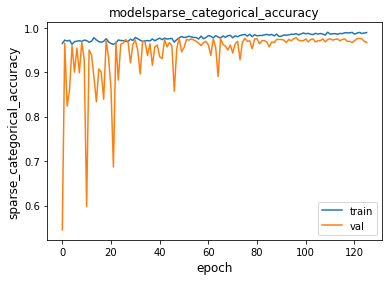

In [15]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model" + metric)
plt.ylabel(metric, fontsize = "large")
plt.xlabel("epoch", fontsize = "large")
plt.legend(["train", "val"], loc = "best")
plt.show()
plt.close()